The goal is to implement a soft snake (solved using Cosserat rod equations) slithering along a flat plane (which supports locomotion via normal and frictional forces). Towards this you first need to implement Cosserat rod equations (based on what we have covered in class so far) and then model the plane forces. Let me discuss them one by one.

For the cosserat rod equations, there are two kinematic equations (one related to translations and another related to rotations) and two dynamic equations (again, one related to translations and another related to rotations). So we tackle this problem in increasing levels of complexity via these milestones:
1) first tackle translations (which are easier to implement) by testing the equations on an elastic beam that is fixed on one end and has a small axial force on the one end. Because the beam is elastic, and the axial force is small, the entire beam behaves like a spring. We can then plot look at how much the beam stretches, which should correspond with analytical spring equations. This is milestone 1.

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import time

# This class is not completely general: only supports uniform mass and single radius
class cosserat_rod:
    # initialize the rod
    def __init__(self, n_elements: int = 100, tot_length = 3.0, rod_density = 5E3, 
                 rod_radius = 0.25, E = 1E6, G = 1E4, velocities = 0, internal_forces = 0):
        
        '''Set up quantities that describe the rod'''
        self.tot_length = tot_length
        self.G = G
        self.E = E
        self.n_elements = n_elements
        self.n_nodes = self.n_elements+1
        element_length = tot_length/n_elements
        # straight rod
        self.positions = np.vstack((np.zeros((2,self.n_nodes)),np.arange(0.0, tot_length+element_length, element_length)))
        
        self.lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)
        self.reference_lengths_bold = self.positions[:, 1:] - self.positions[:, :-1]
        self.reference_lengths_norm = np.linalg.norm(self.reference_lengths_bold, axis=0, keepdims=True)
        
        # this shape is less efficient but easier for us to think about
        # self.directors = np.zeros((n_elements, 3, 3)) 
        self.directors = np.zeros((3, 3, n_elements))
        for idx in range(n_elements):
            self.directors[:, :, idx] = np.eye(3)
        self.directors = np.zeros((3, 3, self.n_elements))
        self.directors[2] = self.lengths_bold/self.lengths_norm
        self.directors[1] = [[0]*self.n_elements, [1]*self.n_elements, [0]*self.n_elements]
        self.directors[0] = np.transpose(np.cross(self.directors[1], self.directors[2], 0, 0))
        
        self.rod_area = np.pi*rod_radius*rod_radius
        self.areas = self.rod_area*np.ones(self.n_elements,)
        
        element_mass = rod_density*element_length*self.rod_area
        self.masses = element_mass*np.ones(self.n_nodes,)
        self.masses[0] *= 0.5
        self.masses[-1] *= 0.5
       
        
        '''Set up quantities that will capture motion'''
        # This way of doing it is bad and should be fixed, will throw error if you try to input your own vals
        self.velocities = velocities if velocities else np.zeros((3, self.n_nodes)) 
        self.internal_forces = internal_forces if internal_forces else np.zeros((3, self.n_nodes))
        
        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        
        self.shear_stiffness_matrix = np.zeros((3, 3, n_elements)) # S
        alpha_c = 4.0 / 3.0
        self.shear_stiffness_matrix[0, 0, :] = alpha_c * self.G * self.areas # S1
        self.shear_stiffness_matrix[1, 1, :] = alpha_c * self.G * self.areas # S2
        self.shear_stiffness_matrix[2, 2, :] = self.E * self.areas # S2
        
        self.tangents = self.lengths_bold / self.lengths_norm   
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :]    

            
    def deltaH_operator(self, t_x): 
        n_pad = [(0,0)] * t_x.ndim
        n_pad[t_x.ndim - 1] = (0,1)
        temp = np.pad(t_x, n_pad, 'constant', constant_values=(0,0))
        return temp - np.roll(temp, 1, t_x.ndim - 1)
    
    # F = ma type calculations - key is to use position at half time step to recalc internal forces, then a
    def Newton2(self, temp_x):
        self.lengths_bold = temp_x[:, 1:] - temp_x[:, :-1]
        self.lengths_norm = np.linalg.norm(self.lengths_bold, axis=0, keepdims=True)

        self.dilatations = self.lengths_norm / self.reference_lengths_norm
        self.tangents = self.lengths_bold / self.lengths_norm
        self.shear_stretch_strains = self.dilatations * self.tangents - self.directors[:, 2, :] # will need to change also in time
        
        self.internal_forces = np.zeros((3,self.n_elements))
        
        self.internal_forces = np.einsum('ijk, jk-> ik', self.shear_stiffness_matrix, self.shear_stretch_strains)/ self.dilatations
        node_forces = self.deltaH_operator(self.internal_forces)
        
#         for elem in range(self.n_elements):
#              self.internal_forces[:,elem] = self.shear_stiffness_matrix[:, :, elem] @ \
#              self.shear_stretch_strains[:,elem] / self.dilatations[0,elem]
#         node_forces = self.modified_diff(self.internal_forces)
        
#         nu = 0.3
#         elem_vels = (self.velocities[:,1:] + self.velocities[:,:-1])/2
#         damping = -elem_vels*self.lengths_bold*nu
#         damping = self.modified_diff(damping)
        dvdt = (node_forces + self.ext_forces) / self.masses    
        return dvdt

    def position_verlet(self, dt, x, v, force_rule):
        temp_x = x + 0.5*dt*v
        v_n = v + dt * force_rule(temp_x)
        self.velocities[:,0] = np.zeros(3,)
        x_n = temp_x + 0.5 * dt * v_n
        self.positions[:,0] = np.zeros(3,)
        return x_n, v_n

    # run the simulation, specifying external conditions ** for now it's just for first benchmark
    def run(self, ext_forces, t_total = 100, dt = 3E-4):
        self.ext_forces = ext_forces
        n_iterations = int(np.ceil(t_total/dt))
        self.position_history = np.zeros((3, self.n_nodes, n_iterations))
        self.position_history[:, :, 0] = self.positions
        for time_step in range(n_iterations):
            self.positions, self.velocities = self.position_verlet(dt, self.positions, self.velocities, self.Newton2)
            # constrain the first element to the wall
            self.positions[:,0] = np.zeros(3,)
            self.velocities[:,0] = np.zeros(3,)
            self.position_history[:, :, time_step] = self.positions
        
        # print what disp should be
        print()
        print('Theoretical displacement (m): ', end = '')
        print(ext_forces[-1,-1]*self.tot_length/(self.E*self.rod_area-ext_forces[-1,-1]))
        print()
        return (self.positions, self.position_history)



Theoretical displacement (m): 0.00022920062769050053


Average end displacement (m): 5.399294564303619e-05



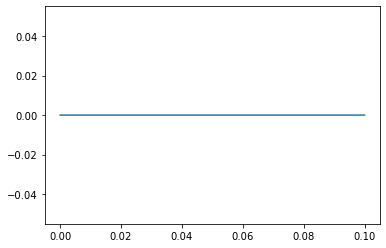

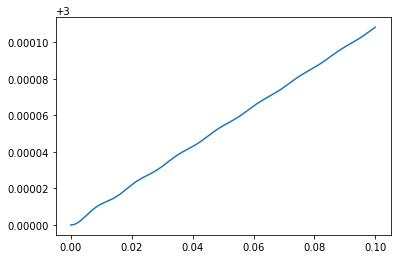

In [9]:
# Milestone 1
stretch_case = cosserat_rod(50)
t_total = 10E-2
dt = 3E-7
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()

In [1]:
stretch_case = cosserat_rod(2)
t_total = 50
dt = 3E-7
ext_force = np.zeros((3, stretch_case.n_nodes))
ext_force[-1, -1] = 15
final_pos, position_history = stretch_case.run(ext_force, t_total, dt)

time_history = np.arange(0, t_total, dt)
plt.plot(time_history, position_history[-1,0,:])
plt.figure()
plt.plot(time_history, position_history[-1,-1,:])
print()
print('Average end displacement (m): ', end = '')
print(np.mean(position_history[-1,-1,:]-position_history[-1,-1, 0]))
print()

NameError: name 'cosserat_rod' is not defined

In [21]:
position_history.shape

(3, 2, 333334)

In [36]:
position_history[0, :, 0]

array([0., 0.])

In [38]:
import pickle as pk
filename = "milestone1.dat"
file = open(filename, "wb")
pk.dump(position_history, file)
file.close()